In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chaii-hindi-and-tamil-question-answering/sample_submission.csv
/kaggle/input/chaii-hindi-and-tamil-question-answering/train.csv
/kaggle/input/chaii-hindi-and-tamil-question-answering/test.csv
/kaggle/input/hf-datasets/wheels/multiprocess-0.70.11.1-py37-none-any.whl
/kaggle/input/hf-datasets/wheels/tqdm-4.49.0-py2.py3-none-any.whl
/kaggle/input/hf-datasets/wheels/huggingface_hub-0.0.9-py3-none-any.whl
/kaggle/input/hf-datasets/wheels/filelock-3.0.12-py3-none-any.whl
/kaggle/input/hf-datasets/wheels/typing_extensions-3.10.0.0-py3-none-any.whl
/kaggle/input/hf-datasets/wheels/certifi-2021.5.30-py2.py3-none-any.whl
/kaggle/input/hf-datasets/wheels/pandas-1.2.4-cp37-cp37m-manylinux1_x86_64.whl
/kaggle/input/hf-datasets/wheels/numpy-1.20.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
/kaggle/input/hf-datasets/wheels/fsspec-2021.6.0-py3-none-any.whl
/kaggle/input/hf-datasets/wheels/datasets-1.7.0-py3-none-any.whl
/kaggle/input/hf-datasets/wheels/python_dateutil-2.8.

# **This is definition from the host:
# 
# For each ID in the test set, you must predict the string that best answers the provided question based on the context. Note that the selected text needs to be quoted and complete to work correctly. Include punctuation, etc. - the above code splits ONLY on whitespace.**

In [2]:
sub = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/sample_submission.csv')
sub.head(1)

,id,PredictionString
0,22bff3dec,NaN


# **What train data do we have available?
# Looks like the training set is very small: 747 Hindi and 368 Tamil examples. We have the context, question, answer_text and answer_start. So this is in fact a reading comprehension task, which means that we have context available and need to find the start and end span in that contexts that answers our question. Typical example of such format is SQUAD.**

In [3]:
train=pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/train.csv")

In [4]:
train.head()

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil


In [5]:
train.language.value_counts()

hindi    746
tamil    368
Name: language, dtype: int64

# ***What about test?**
In test, we have just 5 examples, and similar columns like in train except that we don't have answer_text and answer_start. It seems that answer_text is what we're trying to predict.*****

In [6]:
test = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/test.csv')
test.head()

,id,context,question,language
0,22bff3dec,"ज्वाला गुट्टा (जन्म: 7 सितंबर 1983; वर्धा, महा...",ज्वाला गुट्टा की माँ का नाम क्या है,hindi
1,282758170,गूगल मानचित्र (Google Maps) (पूर्व में गूगल लो...,गूगल मैप्स कब लॉन्च किया गया था?,hindi
2,d60987e0e,गुस्ताव रॉबर्ट किरचॉफ़ (१२ मार्च १८२४ - १७ अक्...,गुस्ताव किरचॉफ का जन्म कब हुआ था?,hindi
3,f99c770dc,அலுமினியம் (ஆங்கிலம்: அலுமினியம்; வட அமெரிக்க ...,அலுமினியத்தின் அணு எண் என்ன?,tamil
4,40dec1964,"கூட்டுறவு இயக்க வரலாறு, இங்கிலாந்து நாட்டில் ...",இந்தியாவில் பசுமை புரட்சியின் தந்தை என்று கருத...,tamil


In [7]:
len(test)

5

# **Metric
# #  We're evaluated based on Jaccard score, which is an intersection over union metric. It's measures how many words from the context we picked correctly.**

**Baseline
Based on: https://github.com/huggingface/notebooks/blob/master/examples/question_answering.ipynb**

In [8]:
import transformers

In [9]:
model_checkpoint="../input/xlm-roberta-squad2/deepset/xlm-roberta-large-squad2"

In [10]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)

In [11]:
train["num_tokens_context"]=train["context"].apply(lambda x: len(tokenizer(x)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (1492 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

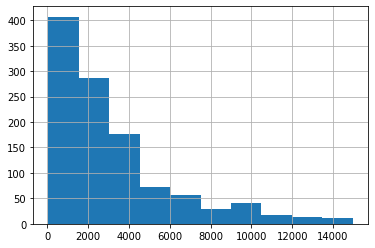

In [12]:
train["num_tokens_context"].hist()

In [13]:
def convert_answers(r):
    start= r[0]
    text= r[1]
    return {
        'answer_start': [start],
        'text': [text]
    }

In [14]:
train = train.sample(frac=1, random_state=42)
train['answers'] = train[['answer_start', 'answer_text']].apply(convert_answers, axis=1)

In [15]:
train

,id,context,question,answer_text,answer_start,language,num_tokens_context,answers
879,cd1339bdd,एरीजोना (English: Arizona) संयुक्त राज्य अमेरि...,एरिज़ोना की राजधानी क्या है?,फ़िनक्स,123,hindi,300,"{'answer_start': [123], 'text': ['फ़िनक्स']}"
101,4c38392a6,"ஆத்திரேலியா, ஆஸ்திரேலியா அல்லது அவுஸ்திரேலியா ...",அவுஸ்திரேலியா நாட்டின் தலைநகரம் எது?,கான்பரா,1472,tamil,7227,"{'answer_start': [1472], 'text': ['கான்பரா']}"
1111,0d35dc007,अग्नि पंचम (अग्नि-५) भारत की अन्तरमहाद्वीपीय ब...,अग्नि पंचम(५) मिसाइल की लम्बाई कितने मीटर है?,17,155,hindi,1330,"{'answer_start': [155], 'text': ['17']}"
726,5b2018761,मदर टेरेसा (२६ अगस्त १९१० - ५ सितम्बर १९९७) जि...,मदर टेरेसा की राष्ट्रीयता क्या थी?,भारतीय,328,hindi,1694,"{'answer_start': [328], 'text': ['भारतीय']}"
291,4f99ce2e0,"எம். ஜி. ஆர் என்ற பெயரில் புகழ் பெற்ற, மருதூர்...",நடிகர் ம. கோ. இராமச்சந்திரன் எப்போது பிறந்தார்?,"சனவரி 17, 1917",99,tamil,4898,"{'answer_start': [99], 'text': ['சனவரி 17, 191..."
...,...,...,...,...,...,...,...,...
466,3acaa3b86,अरस्तु (384 ईपू – 322 ईपू) यूनानी दार्शनिक थे।...,अरस्तु का जन्म कहाँ हुआ था?,स्टेगेरिया,97,hindi,1433,"{'answer_start': [97], 'text': ['स्टेगेरिया']}"
121,7a3e4bf22,சிந்துவெளி நாகரிகம் (Indus Valley Civilisation...,சிந்து சமவெளி நாகரிகம் எப்போது உருவானது?,கி.மு 3000,305,tamil,4319,"{'answer_start': [305], 'text': ['கி.மு 3000']}"
1044,de34ee0a0,Main Page\n\nआई एन एस (INS) विक्रमादित्य (San...,आई एन एस विक्रमादित्य युद्धपोत किस कंपनी द्वार...,माइकोलैव ब्लैक ‍सी शिपयार्ड,460,hindi,3129,"{'answer_start': [460], 'text': ['माइकोलैव ब्ल..."
1095,518fc3aaf,"अमेरिकी क्रन्तिकारी युद्ध (1775–1783), जिसे सं...",कितने अमेरिकी उपनिवेश अमेरिकी क्रांति का हिस्स...,तेरह,147,hindi,7119,"{'answer_start': [147], 'text': ['तेरह']}"


In [16]:
df_train = train[:-64].reset_index(drop=True)
df_valid = train[-64:].reset_index(drop=True)


In [17]:
df_train.head()

,id,context,question,answer_text,answer_start,language,num_tokens_context,answers
0,cd1339bdd,एरीजोना (English: Arizona) संयुक्त राज्य अमेरि...,एरिज़ोना की राजधानी क्या है?,फ़िनक्स,123,hindi,300,"{'answer_start': [123], 'text': ['फ़िनक्स']}"
1,4c38392a6,"ஆத்திரேலியா, ஆஸ்திரேலியா அல்லது அவுஸ்திரேலியா ...",அவுஸ்திரேலியா நாட்டின் தலைநகரம் எது?,கான்பரா,1472,tamil,7227,"{'answer_start': [1472], 'text': ['கான்பரா']}"
2,0d35dc007,अग्नि पंचम (अग्नि-५) भारत की अन्तरमहाद्वीपीय ब...,अग्नि पंचम(५) मिसाइल की लम्बाई कितने मीटर है?,17,155,hindi,1330,"{'answer_start': [155], 'text': ['17']}"
3,5b2018761,मदर टेरेसा (२६ अगस्त १९१० - ५ सितम्बर १९९७) जि...,मदर टेरेसा की राष्ट्रीयता क्या थी?,भारतीय,328,hindi,1694,"{'answer_start': [328], 'text': ['भारतीय']}"
4,4f99ce2e0,"எம். ஜி. ஆர் என்ற பெயரில் புகழ் பெற்ற, மருதூர்...",நடிகர் ம. கோ. இராமச்சந்திரன் எப்போது பிறந்தார்?,"சனவரி 17, 1917",99,tamil,4898,"{'answer_start': [99], 'text': ['சனவரி 17, 191..."


In [18]:
from datasets import Dataset

In [19]:
!pip uninstall fsspec -qq -y
!pip install --no-index --find-links ../input/hf-datasets/wheels datasets -qq

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
s3fs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2021.6.0 which is incompatible.
pytorch-lightning 1

In [20]:
train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_valid)

In [21]:
train_dataset[0]

{'id': 'cd1339bdd',
 'context': 'एरीजोना (English: Arizona) संयुक्त राज्य अमेरिका के दक्षिणपश्चिमी हिस्से में स्थित राज्य है। इसका सबसे बड़ा शहर और राजधानी फ़िनक्स है। दूसरा सबसे बड़ा राज्य टक्सन है और उसके बाद फ़िनक्स के महानगर क्षेत्र स्थित शहर मेसा, ग्लेनडेल, चंदलर और स्कोत्ट्सडेल है।\nएरीजोना संयुक्त राज्यों में शामिल होने वाला ४८व राज्य था जिसे की इसमें १४ फरबरी १९१२ को समिलित किया गया। इसी दिन इस राज्य की देश में माने जाने वाली भूमि की वर्षागाठ भी थी। एरीजोना अपने रेगिस्तानी मौसम, भयंकर गर्मी और हल्की ठंड के लिए जाना जाता है। पर राज्य के उच्च इलाकों में बहुत पहाड़ व जंगल है, इसी कारण वहाँ का मौसम अन्य राज्य के मुकाबले ठंडा रहता है। जुलाई १ २००६ के अनुसार एरीजोना देश में आबादी के हिसाब से सबसे तेजी से बढ़ता राज्य है। इससे पहले यह दर्जा नेवादा के पास था।\nराज्य का एक-चौथाई इलाका मूल अमेरिकी आदिवासी के लिये संरक्षित है। राज्य की आधिकरिक भाषा अँग्रेजी है जिसे बोलने वाले जनसंख्या के 74 प्रतिशत है। स्पेनी 19.5 प्रतिशत द्वारा बोली जाती है। 2015 में राज्य की आबादी 68,28,065 अनुमानित की ग

In [22]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128
pad_on_right = tokenizer.padding_side == "right"
batch_size=4

In [23]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [24]:
tokenized_train_ds = train_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
tokenized_valid_ds = valid_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [25]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [26]:
args = TrainingArguments(
    f"chaii-qa",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    warmup_ratio=0.1,
    gradient_accumulation_steps=8,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
)

In [27]:
from transformers import default_data_collator

data_collator = default_data_collator

In [28]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [30]:
pip install wandb --upgrade

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [31]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13925
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 435
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss
0,No log,0.284637


***** Running Evaluation *****
  Num examples = 816
  Batch size = 4
Saving model checkpoint to chaii-qa/checkpoint-435
Configuration saved in chaii-qa/checkpoint-435/config.json
Model weights saved in chaii-qa/checkpoint-435/pytorch_model.bin
tokenizer config file saved in chaii-qa/checkpoint-435/tokenizer_config.json
Special tokens file saved in chaii-qa/checkpoint-435/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=435, training_loss=0.2638397918350395, metrics={'train_runtime': 1920.7108, 'train_samples_per_second': 7.25, 'train_steps_per_second': 0.226, 'total_flos': 9695700997816320.0, 'train_loss': 0.2638397918350395, 'epoch': 1.0})

In [32]:
trainer.save_model("chaii-bert-trained")

Saving model checkpoint to chaii-bert-trained
Configuration saved in chaii-bert-trained/config.json
Model weights saved in chaii-bert-trained/pytorch_model.bin
tokenizer config file saved in chaii-bert-trained/tokenizer_config.json
Special tokens file saved in chaii-bert-trained/special_tokens_map.json


In [33]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples


In [34]:
validation_features = valid_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=valid_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [35]:
validation_features

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 816
})

In [36]:
valid_feats_small = validation_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
valid_feats_small

  0%|          | 0/816 [00:00<?, ?ex/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 816
})

In [37]:
len(validation_features)

816

In [38]:
raw_predictions = trainer.predict(valid_feats_small)

***** Running Prediction *****
  Num examples = 816
  Batch size = 4


In [39]:
max_answer_length = 30
import collections

examples = valid_dataset
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [40]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        predictions[example["id"]] = best_answer["text"]

    return predictions

In [41]:
final_predictions = postprocess_qa_predictions(valid_dataset, validation_features, raw_predictions.predictions)

Post-processing 64 example predictions split into 816 features.


  0%|          | 0/64 [00:00<?, ?it/s]

In [42]:
references = [{"id": ex["id"], "answer": ex["answers"]['text'][0]} for ex in valid_dataset]


In [43]:
final_predictions

OrderedDict([('dc64d02cf', 'प्रतिभा पाटील'),
             ('98d8542f6', ' பிங்க்'),
             ('3ce81e663', 'मिर्ज़ा असद-उल्लाह बेग ख़ां'),
             ('40f4e32da', ' मीटर प्रति सेकेण्ड2'),
             ('bfa4380bd', ' अगरतला'),
             ('914cd633c', ' ஐந்து'),
             ('daddbeba7', ' ३०'),
             ('02221d130', ' 118'),
             ('8069e0eea', ' 2.'),
             ('7c10c457f', ' सूर्यकांत त्रिपाठी निराला'),
             ('c67476278', ' वॉशिंगटन, डी॰ सी॰'),
             ('d6c9beda1', ' मेगावती सेतियावती सुकर्णोपुत्री'),
             ('7c73a8caa', ' ४,४५,७९,००० किमी'),
             ('35ed7e197', ' (2003)'),
             ('6f54ca7b7', ' 25 दिसम्बर 1984'),
             ('2c9fa8009', ' கோஹிமா'),
             ('90299b7e0', ' 26 மே 2001'),
             ('ae4dacbc2', ' अँग्रेजी'),
             ('481ebd62d', 'वारसा - Warsaw'),
             ('0c38e66fa', '\nकनाडा सार्वजनिक सुरक्षा'),
             ('4109d6286', ' டான் பிரவுனால்'),
             ('b09a0244d', ' सैफ अली खान'

In [44]:
def jaccard(row): 
    str1 = row[0]
    str2 = row[1]
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [45]:
res = pd.DataFrame(references)
res['prediction'] = res['id'].apply(lambda r: final_predictions[r])
res['jaccard'] = res[['answer', 'prediction']].apply(jaccard, axis=1)
res

,id,answer,prediction,jaccard
0,dc64d02cf,प्रतिभा पाटील,प्रतिभा पाटील,1.000000
1,98d8542f6,பிங்க்,பிங்க்,1.000000
2,3ce81e663,मिर्ज़ा असद-उल्लाह बेग ख़ां,मिर्ज़ा असद-उल्लाह बेग ख़ां,1.000000
3,40f4e32da,मीटर प्रति सेकेण्ड2,मीटर प्रति सेकेण्ड2,1.000000
4,bfa4380bd,अगरतला,अगरतला,1.000000
...,...,...,...,...
59,3acaa3b86,स्टेगेरिया,स्टेगेरिया,1.000000
60,7a3e4bf22,கி.மு 3000,கி.மு 6000,0.333333
61,de34ee0a0,माइकोलैव ब्लैक ‍सी शिपयार्ड,यूक्रेन के माइकोलैव ब्लैक ‍सी शिपयार्ड,0.666667
62,518fc3aaf,तेरह,तेरह,1.000000


In [46]:
res.jaccard.mean()

0.6622395833333333

**Test predict and submit
Ok, so we got 0.66 average jaccard score on our validation set (the score can differ when I re-run the notebook). Next step is to run it on test and submit :)**

In [47]:
test=pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/test.csv")

In [48]:
test_dataset = Dataset.from_pandas(test)

In [49]:
test_features = test_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=test_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
test_feats_small = test_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
test_feats_small

  0%|          | 0/67 [00:00<?, ?ex/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 67
})

In [51]:
test_predictions = trainer.predict(test_feats_small)

***** Running Prediction *****
  Num examples = 67
  Batch size = 4


In [52]:
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

In [53]:
final_test_predictions = postprocess_qa_predictions(test_dataset, test_features, test_predictions.predictions)

Post-processing 5 example predictions split into 67 features.


  0%|          | 0/5 [00:00<?, ?it/s]

In [54]:
sub=pd.read_csv("../input/chaii-hindi-and-tamil-question-answering/sample_submission.csv")

In [55]:
sub['PredictionString'] = sub['id'].apply(lambda r: final_test_predictions[r])
sub.head()

,id,PredictionString
0,22bff3dec,येलन चीन
1,282758170,20 अप्रैल 2010
2,d60987e0e,१२ मार्च १८२४
3,f99c770dc,13
4,40dec1964,சுவாமிநாதன் மற்றும் வர்கீஸ் குரியன்


In [56]:
sub.to_csv('submission.csv', index=False)